In [1]:

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
sys.path.append(os.path.abspath("../lib"))
from merge import prepare_train_show

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning) 

In [2]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

In [3]:
# import files
# File location and type
file_location_array = [
    {"location": "../training/pred_dpe.csv", "name": "dpe", "delimiter": ","},
    {"location": "../training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [4]:
dpe = dataframes['dpe']
dpe_training = dpe.drop('GES_emission')
ges_training = dpe.drop('DPE_consumption')
dictionary = dataframes['dictionary']

In [5]:
# librairies
import numpy as np
import matplotlib.pyplot as plt

# usefull
from copy import deepcopy

# linear
from sklearn.linear_model import LogisticRegression

# random forest
from sklearn.ensemble import RandomForestClassifier

# XGboost
from xgboost.sklearn import XGBClassifier

#hyperparams
from scipy.stats import uniform, randint
from sklearn.metrics import make_scorer

# categorical

# DPE

0.3990912208504801 {'C': 439.9714207056361, 'class_weight': 'balanced', 'max_iter': 1000}
0.4173954046639232 {'class_weight': 'balanced', 'max_depth': 39, 'n_estimators': 112}
0.4179098079561043 {'learning_rate': 0.17813867890931723, 'n_estimators': 186}


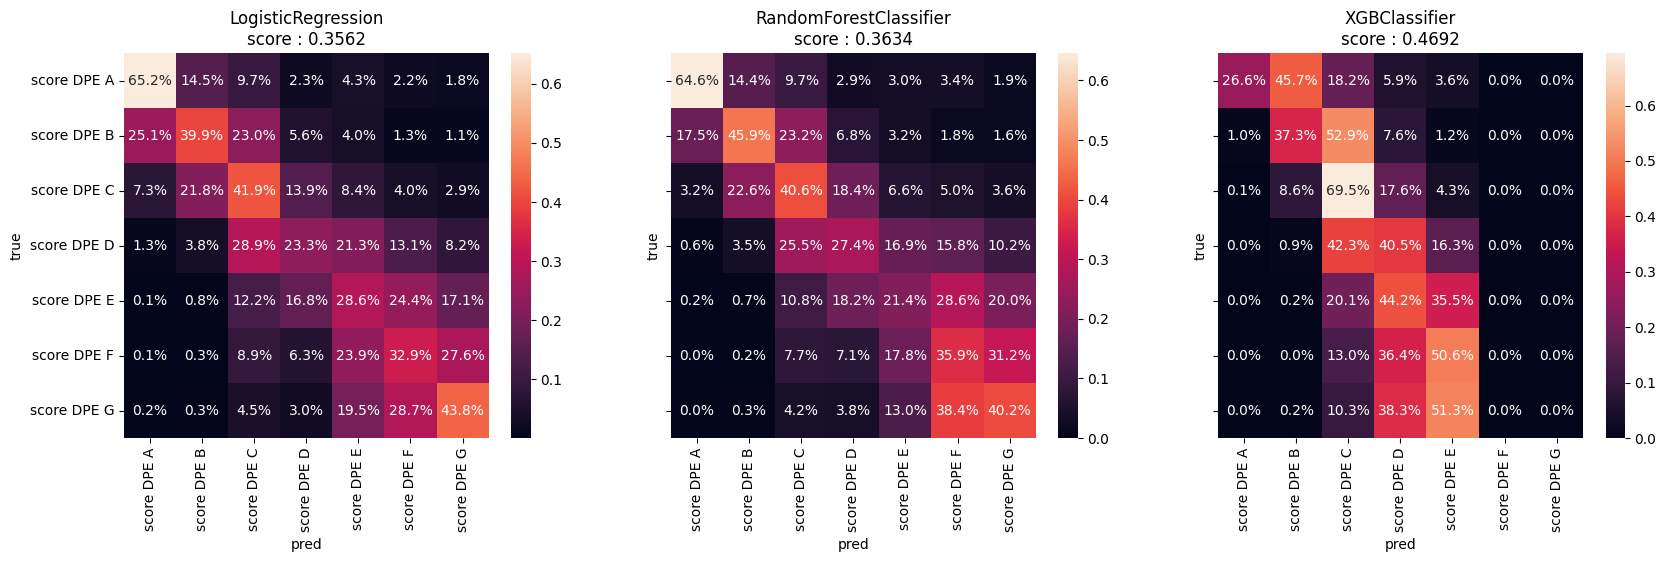

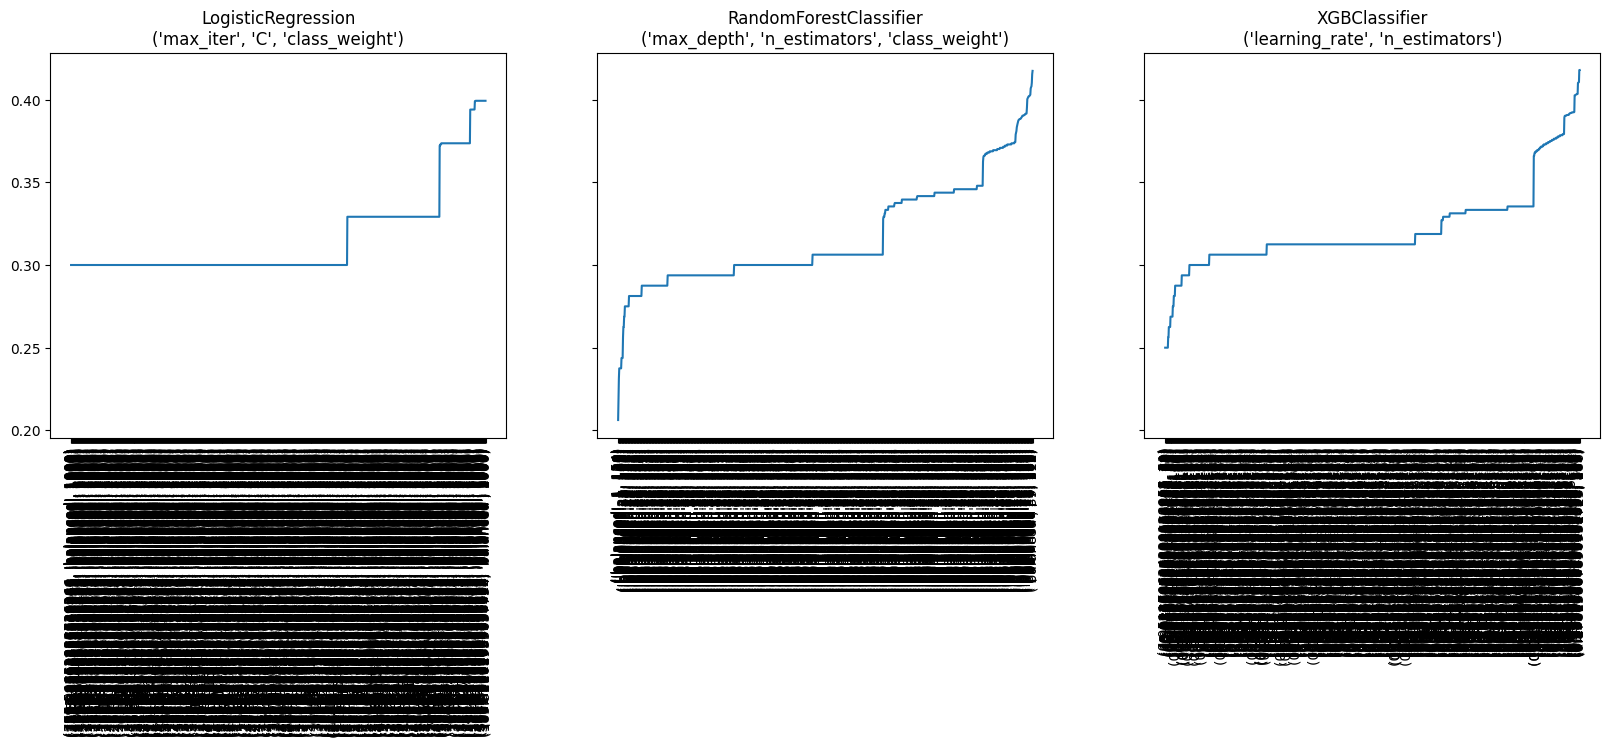

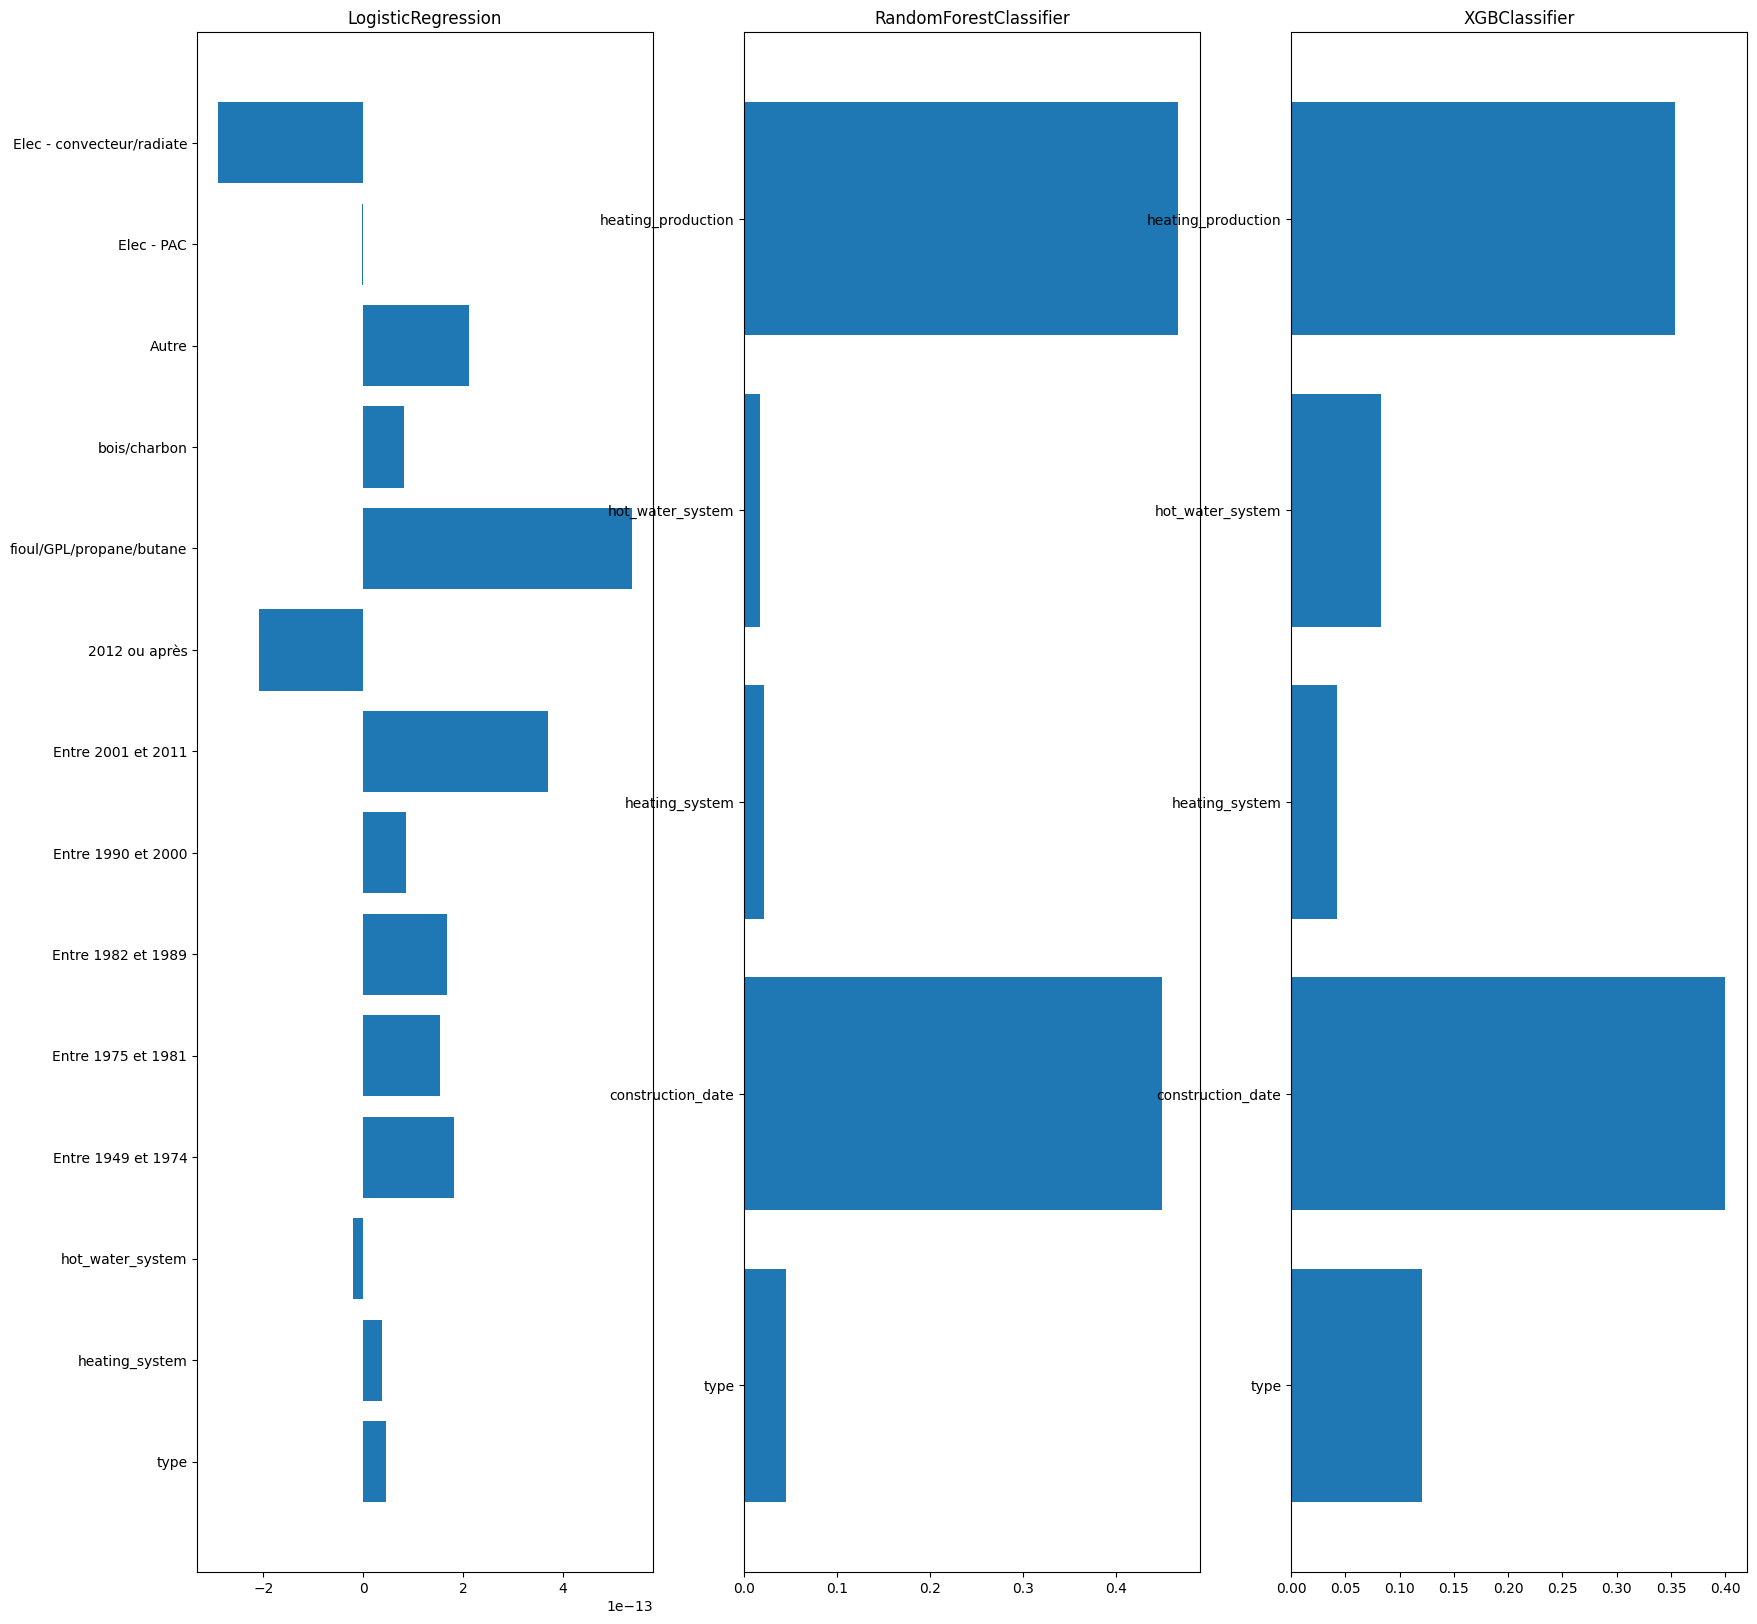

In [6]:
col_X_hot = [['construction_date', 'heating_production'],
            [],
            []]
col_y = ['DPE_consumption']
col_X_not_hot = [[col[0] for col in dpe_training.dtypes if col[0] not in col_X_hot[i] + col_y] for i in range(len(col_X_hot))]

categorical_features = [i for i in range(6)]

hyperparams_models = [
    {
        'max_iter': [1000],
        'C': uniform(1,1000),
        'class_weight': ['balanced'],
    },
    {
        'max_depth' : randint(1,50),
        'n_estimators': randint(100,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'class_weight': ['balanced'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    },
    {
        'learning_rate': uniform(0.03,0.3),
        'n_estimators': randint(50,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'LogisticRegression': LogisticRegression,
    'RandomForestClassifier' : RandomForestClassifier,
    'XGBClassifier' : XGBClassifier,
}
best_models_ges = prepare_train_show(dpe_training, dictionary, categorical_features, col_X_hot, col_X_not_hot, col_y,
                         False, True, hyperparams_models, models, random_state=42, test_size=0.4, scoring='f1_micro', smote=True, treshold=50000)


# GES 

0.45771604938271604 {'C': 893.5589984899777, 'class_weight': 'balanced', 'max_iter': 1000}
0.46788408779149526 {'class_weight': 'balanced', 'max_depth': 27, 'n_estimators': 134}
0.4674982853223594 {'learning_rate': 0.09818088817894544, 'n_estimators': 60}


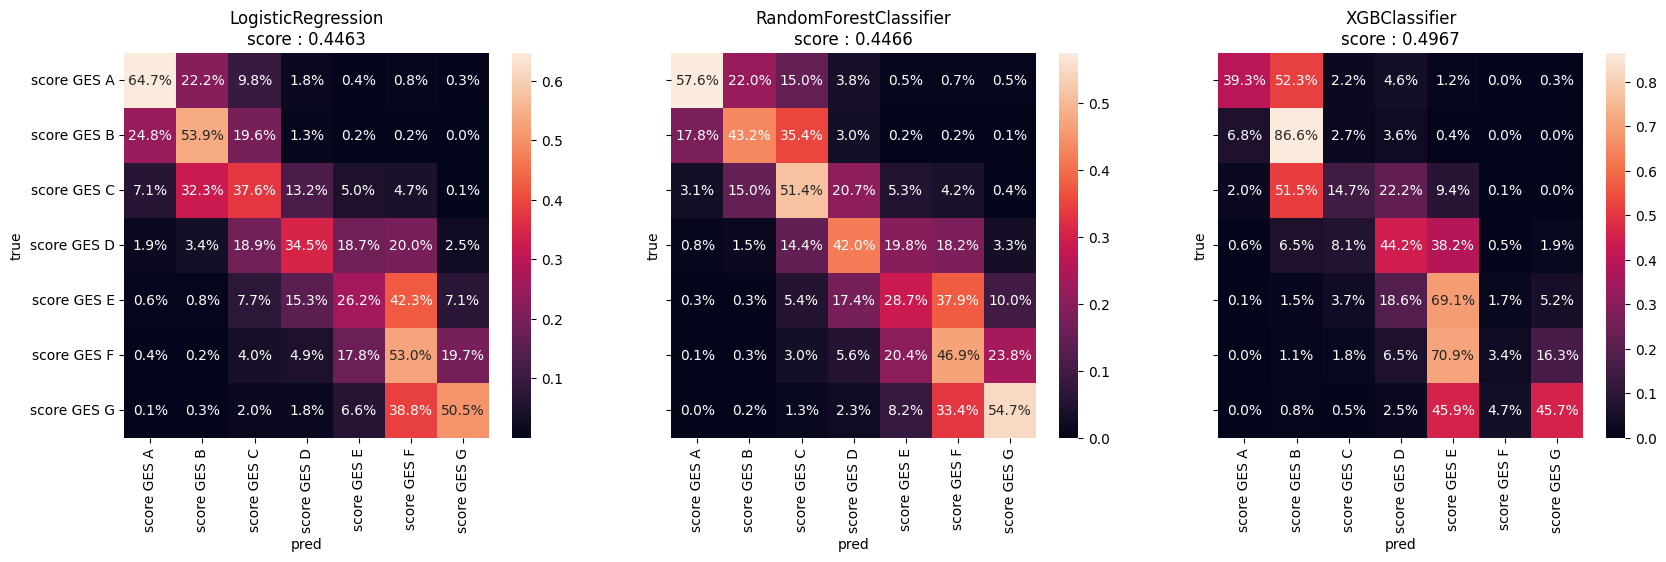

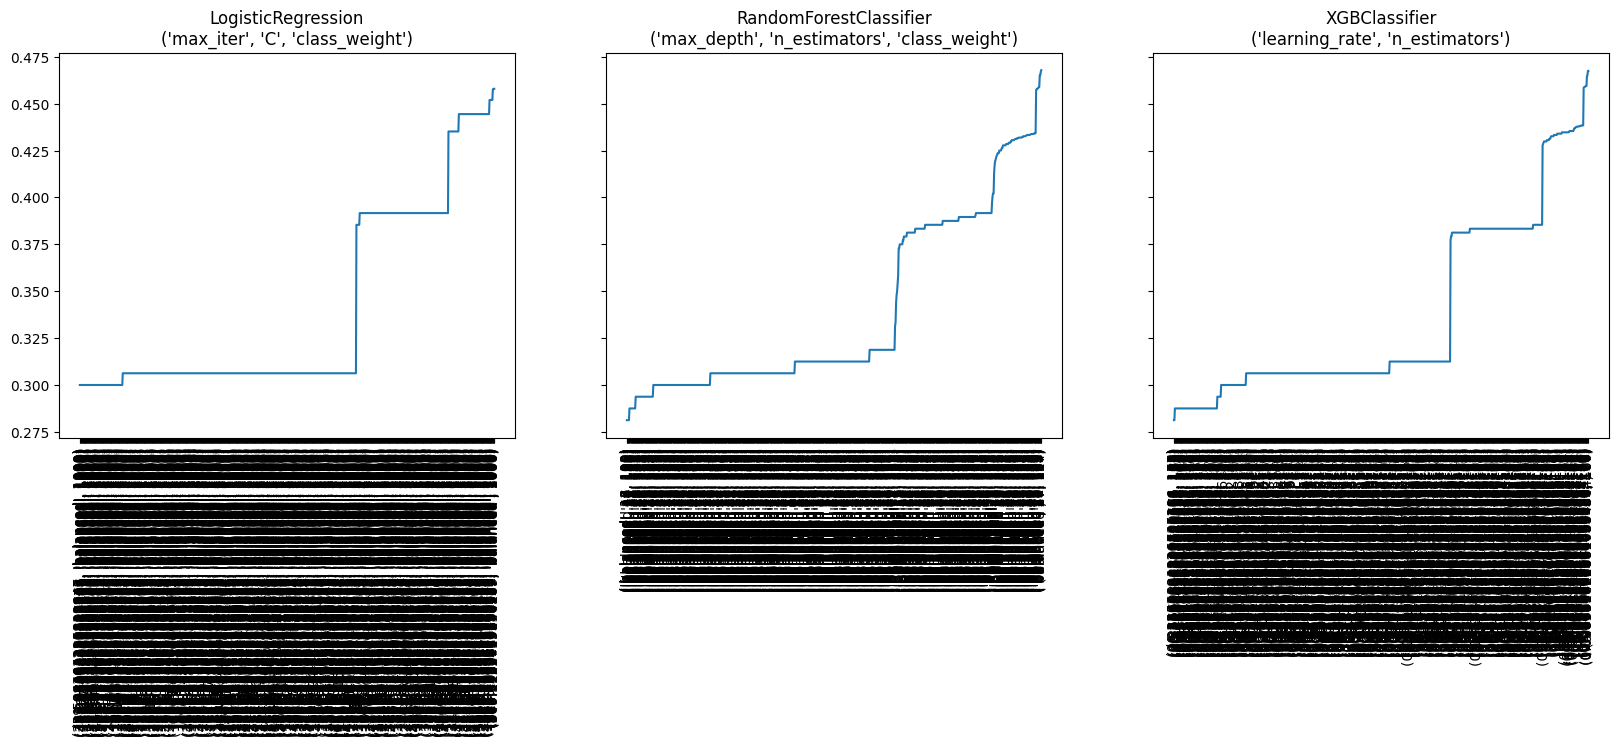

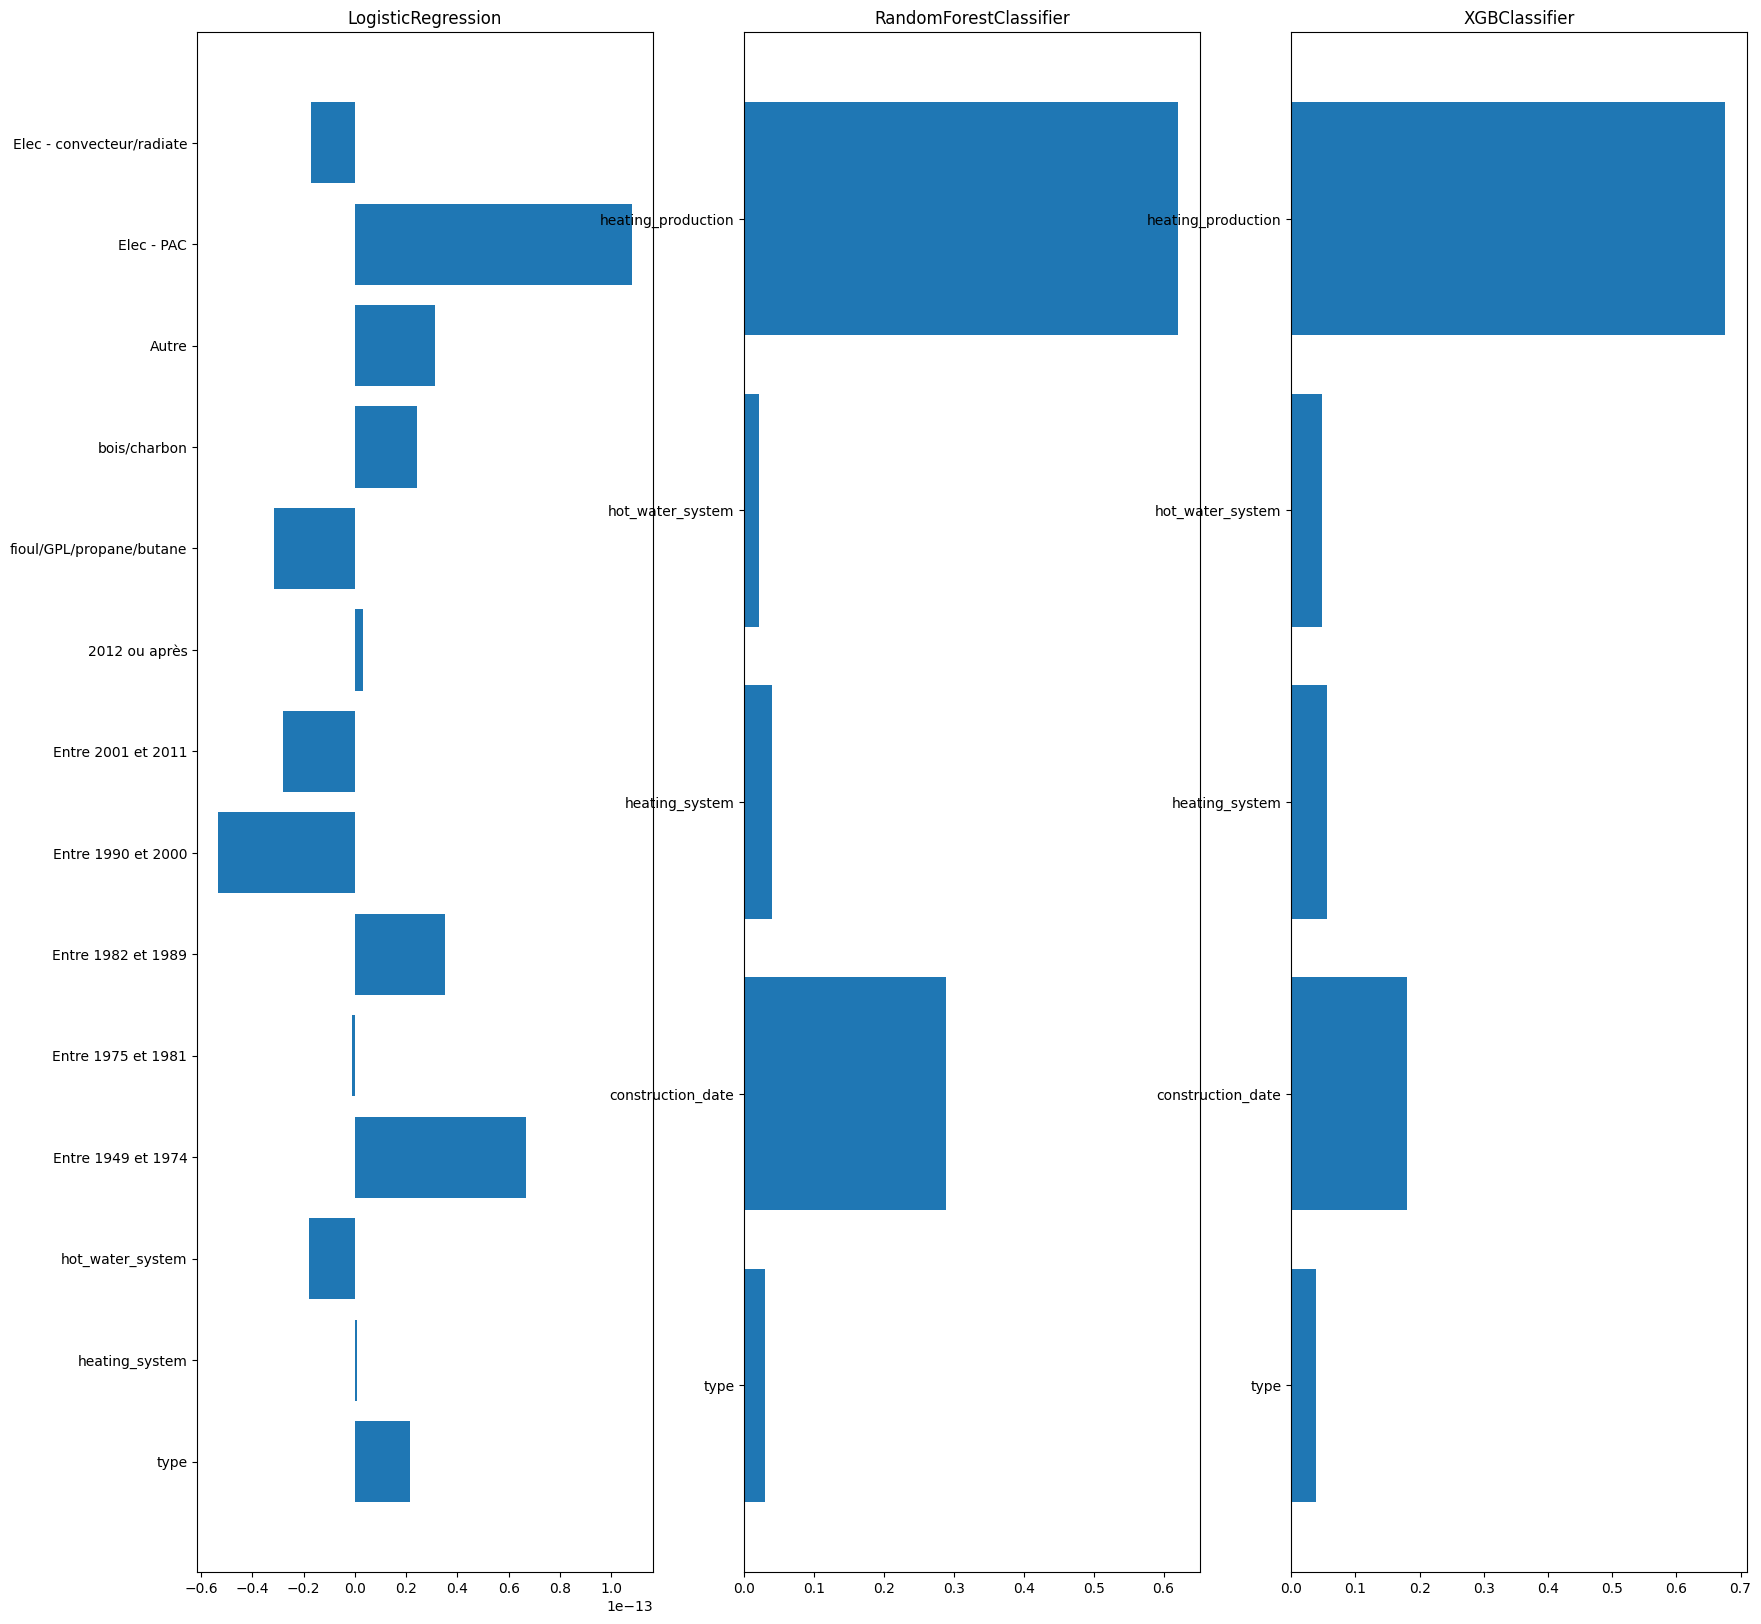

In [7]:
col_X_hot = [['construction_date', 'heating_production'],
            [],
            []]
col_y = ['GES_emission']
col_X_not_hot = [[col[0] for col in ges_training.dtypes if col[0] not in col_X_hot[i] + col_y] for i in range(len(col_X_hot))]

categorical_features = [i for i in range(6)]

hyperparams_models = [
    {
        'max_iter': [1000],
        'C': uniform(1,1000),
        'class_weight': ['balanced'],
    },
    {
        'max_depth' : randint(1,50),
        'n_estimators': randint(100,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        'class_weight': ['balanced'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    },
    {
        'learning_rate': uniform(0.03,0.3),
        'n_estimators': randint(50,200),
        # 'subsample' : [0.2, 0.5, 0.8, 1],
        # 'criterion' : ['friedman_mse', 'squared_error'],
        # 'max_features' : {'auto', 'sqrt', 'log2'}
        # 'min_samples_split' : [2,5,10],
        # 'min_samples_leaf' : [1,2,3],
    }
]
models = {
    'LogisticRegression': LogisticRegression,
    'RandomForestClassifier' : RandomForestClassifier,
    'XGBClassifier' : XGBClassifier,
}
best_models_ges_2 = prepare_train_show(ges_training, dictionary, categorical_features, col_X_hot, col_X_not_hot, col_y,
                         False, True, hyperparams_models, models, random_state=42, test_size=0.4, scoring='f1_micro', smote=True, treshold=50000)
